
# Conditional autoregressive transformer

Train a transformer to predict missing pixel from mnist 

### plan

* note to try padded mnist (relative encoding might require black padding???)
* probably don't need positional encoding?
* create transformer model
* masking 
* randomised masking
* relative position encoding (x - current_x, y - current_y, val)
* train to predict when current pixel missing
* train to predict when 10% are missing
* train to predict when 90% are missing
* train to predict when 99% are missing



In [1]:
model_name = "txformer-bigger-3"

In [26]:
# Init weights and biases project

import wandb
from wandb.keras import WandbCallback


wandb.init(project='conditional-mnist', entity='maxeonyx')
config = wandb.config
config.learning_rate = 0.01

In [3]:
# reserve GPU 0 only (for VUW machines)

import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
# start tensorflow

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

tf.constant([1])

2021-09-30 07:15:39.413140: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-30 07:15:39.965954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:3b:00.0, compute capability: 7.5


<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>

In [5]:
from PIL import Image, ImageDraw
from IPython.display import display

def display_uint8_image(image):
    if len(image.shape) == 3:
        image = image[:, :, 0]
    if tf.is_tensor(image):
        image = image.numpy()
    display(Image.fromarray(image, "L"))

def display_float32_image(image):
    if len(image.shape) == 3:
        image = image[:, :, 0]
    if tf.is_tensor(image):
        image = image.numpy()
    display_uint8_image(image.astype(np.uint8))

In [6]:
def idxs_to_onehots(idxs, depth=784):
    onehots = tf.one_hot(idxs, depth, dtype=tf.bool, on_value=False, off_value=True)
    return onehots

# takes 2D tensor (batch and index list)
def idxs_to_multihot(idxs, depth=784):
    onehots = idxs_to_onehots(idxs, depth)
    multihot = tf.math.reduce_all(onehots, axis=len(onehots.shape)-2)
    return multihot

def idxs_to_attention_mask(idxs):
    multihot = idxs_to_multihot(idxs)
    attn_mask = tf.logical_and(multihot[:, :, None], multihot[:, None, :])
    return attn_mask

def mask_to_image_mask(mask):
    image_mask = tf.reshape(mask, [28, 28])
    return image_mask

# scale is the max-min of vals
# for mnist it's 28 because thats the width and height of the images
def positional_encoding(vals, dims, scale=1000):

    i = tf.range(dims//2, dtype=tf.float32)
    i = tf.expand_dims(i, -2)
    
    vals = tf.expand_dims(vals, -1)
    
    # the bit inside the sin / cos
    rate = vals / tf.pow(scale, 2.*i/dims)
    
    sin = tf.sin(rate)
    cos = tf.cos(rate)
    
#     # expand dims to allow alternating concat
#     sin = tf.expand_dims(sin, -1)
#     cos = tf.expand_dims(cos, -1)
    
    encoding = tf.concat([sin, cos], axis=-1)
    
#     encoding = tf.reshape(encoding, [-1, dims])
    
    return encoding

print(positional_encoding(tf.constant([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]), 8))

def img_to_tuples(img):
    
    height, width, chan = img.shape
    length = height * width
    vals = tf.reshape(img, [length])
    vals = tf.cast(vals, tf.float32)
    rows = tf.range(height, dtype=tf.float32)
    cols = tf.range(width, dtype=tf.float32)
    cols, rows = tf.meshgrid(rows, cols)
    rows = tf.reshape(rows, [-1])
    cols = tf.reshape(cols, [-1])
    
    # permute the order, to ensure the network uses the positional encoding and not the implicit locaiton
    idxs = tf.range(length)
    idxs = tf.random.shuffle(idxs)
    
    rows = tf.gather(rows, idxs)
    cols = tf.gather(cols, idxs)
    vals = tf.gather(vals, idxs)
    
    return vals, rows, cols

def random_mask(n_masked_out=None):
    
    def call():
        idxs = tf.range(784)
        idxs = tf.random.shuffle(idxs)
        if n_masked_out is None:
            n = tf.random.uniform(shape=[], maxval=784, dtype=tf.int32)
        else:
            n = n_masked_out
        idxs = idxs[:n]
        return idxs_to_multihot(idxs)
    
    return call

def random_square_mask(maxsize=28):
    height = tf.random.uniform(shape=[], minval=1, maxval=maxsize, dtype=tf.int32)
    width = tf.random.uniform(shape=[], minval=1, maxval=maxsize, dtype=tf.int32)
    start_row = tf.random.uniform(shape=[], minval=0, maxval=maxsize-height, dtype=tf.int32)
    start_col = tf.random.uniform(shape=[], minval=0, maxval=maxsize-width, dtype=tf.int32)
    rows = tf.range(start_row, start_row + height)
    cols = tf.range(start_col, start_col + width)
    cols, rows = tf.meshgrid(rows, cols)
    idxs = rows*maxsize+cols
    idxs = tf.reshape(idxs, [-1])
    return idxs_to_multihot(idxs, depth=maxsize*maxsize)

def random_offset():
    return tf.random.uniform(shape=[2], maxval=28, dtype=tf.int32)
    
def display_mask(mask):
    image_mask = np.array(mask_to_image_mask(mask), np.uint8)
    image_mask = image_mask * 255
    display_uint8_image(image_mask)

tf.Tensor(
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00]
 [ 7.0710683e-01  1.3921213e-01  2.4833918e-02  4.4166050e-03
   7.0710677e-01  9.9026257e-01  9.9969161e-01  9.9999022e-01]
 [ 1.0000000e+00  2.7571312e-01  4.9652517e-02  8.8331243e-03
  -4.3711388e-08  9.6123999e-01  9.9876654e-01  9.9996096e-01]
 [ 7.0710683e-01  4.0684462e-01  7.4440487e-02  1.3249470e-02
  -7.0710677e-01  9.1349739e-01  9.9722546e-01  9.9991220e-01]
 [-8.7422777e-08  5.3005296e-01  9.9182546e-02  1.7665559e-02
  -1.0000000e+00  8.4796453e-01  9.9506927e-01  9.9984396e-01]], shape=(5, 8), dtype=float32)


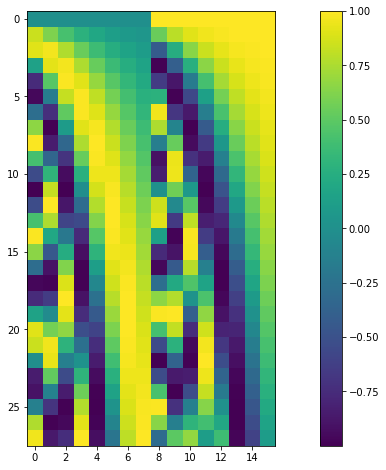

In [7]:
from matplotlib import pyplot as plt
positions = tf.range(28, dtype=tf.float32)
encodings = positional_encoding(positions, 16, scale=28)
fig, ax = plt.subplots(figsize=(16, 8))
im = ax.imshow(encodings)
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

In [8]:
# tensorflow.data data generator

from tensorflow import data as td
import tensorflow_datasets as tfds

def make_dataset_generator(split='train'):
    
    def split_enumerate(i, data):
        data["index"] = i
        return data
    
    def map_add(component, func):
        def do(data):
            data[component] = func()
            return data
        return do
    
    def add_tuples(data):
        data['vals'], data['rows'], data['cols'] = img_to_tuples(data['image'])
        return data
    
    def add_square_mask(data):
        mask = data['mask']
        square_mask = random_square_mask()
        mask = tf.logical_and(mask, square_mask)
        data['mask'] = mask
        return data
    
    dataset = tfds.load('mnist', split=split, shuffle_files=True)
    
    # keep track of the index in the original MNIST
    dataset = dataset.enumerate()
    dataset = dataset.map(split_enumerate)
    
    # shuffle the digits
    dataset = dataset.shuffle(60000)
    # repeat the dataset infinitely
    dataset = dataset.repeat()
    
    dataset = dataset.map(add_tuples)
    
    dataset = dataset.map(map_add('mask', random_mask(500)))
    dataset = dataset.map(add_square_mask)
    
    return dataset

dataset_train = make_dataset_generator()
dataset_test = make_dataset_generator(split='test')

In [9]:
def dataset_summary(d):
    for el in d.take(1):
        for name, v in el.items():
            print(name, "shape", v.shape)
            print(name, "dtype", v.dtype)

    for el in d.take(5):
        print("index", el["index"], "which is a", el["label"])
        display_uint8_image(el["image"])
        display_mask(el["mask"])
        display_uint8_image(tf.reshape(el["image"], [28, 28]) * tf.cast(mask_to_image_mask(el["mask"]), tf.uint8))

dataset_summary(dataset_train)
dataset_summary(dataset_test)

2021-09-30 07:15:42.161213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


image shape (28, 28, 1)
image dtype <dtype: 'uint8'>
label shape ()
label dtype <dtype: 'int64'>
index shape ()
index dtype <dtype: 'int64'>
vals shape (784,)
vals dtype <dtype: 'float32'>
rows shape (784,)
rows dtype <dtype: 'float32'>
cols shape (784,)
cols dtype <dtype: 'float32'>
mask shape (784,)
mask dtype <dtype: 'bool'>
index tf.Tensor(17593, shape=(), dtype=int64) which is a tf.Tensor(6, shape=(), dtype=int64)


index tf.Tensor(22288, shape=(), dtype=int64) which is a tf.Tensor(8, shape=(), dtype=int64)


index tf.Tensor(6959, shape=(), dtype=int64) which is a tf.Tensor(6, shape=(), dtype=int64)


index tf.Tensor(22313, shape=(), dtype=int64) which is a tf.Tensor(2, shape=(), dtype=int64)


index tf.Tensor(11081, shape=(), dtype=int64) which is a tf.Tensor(6, shape=(), dtype=int64)


image shape (28, 28, 1)
image dtype <dtype: 'uint8'>
label shape ()
label dtype <dtype: 'int64'>
index shape ()
index dtype <dtype: 'int64'>
vals shape (784,)
vals dtype <dtype: 'float32'>
rows shape (784,)
rows dtype <dtype: 'float32'>
cols shape (784,)
cols dtype <dtype: 'float32'>
mask shape (784,)
mask dtype <dtype: 'bool'>
index tf.Tensor(5121, shape=(), dtype=int64) which is a tf.Tensor(4, shape=(), dtype=int64)


index tf.Tensor(1328, shape=(), dtype=int64) which is a tf.Tensor(5, shape=(), dtype=int64)


index tf.Tensor(7488, shape=(), dtype=int64) which is a tf.Tensor(2, shape=(), dtype=int64)


index tf.Tensor(5961, shape=(), dtype=int64) which is a tf.Tensor(4, shape=(), dtype=int64)


index tf.Tensor(5588, shape=(), dtype=int64) which is a tf.Tensor(4, shape=(), dtype=int64)


## Attention Maths

Dimensions $N$, $D$, $E$ and $B$.

- $N = 784$ is the number of inputs.
- $D$ is the width of the _key_ $K$ and _query_ $Q$ vectors.
- $E$ is the width of the _value_ vectors $V$.
- There is also a (or multiple) batch dimension(s) $B$.

$K$ is $B \times N \times D$ dimensional.
$Q$ is $B \times N \times D$ dimensional.
$V$ is $B \times N \times E$ dimensional.
Because it is self-attention, $K$ and $Q$ have the same length $N$, and the attention matrix is square.
The attention matrix is $A = Q \cdot K^T$, and is $B \times N \times N$ dimensional. Formally:
$$
A_{b,i,j} = \sum_d Q_{b,i,d} K_{b,j,d}
$$

We do softmax normalization along the columns $j$ of the attention matrix (such that each _row_ $i$ sums to 1). The result is the attention weights. Formally:
$$
\bar{A}_{b,i,j} = \frac{e^{A_{b,i,j}}}{\sum_{j'} e^{A_{b,i,j'}}}
$$

The output $O$ of the attention layer is $B \times N \times E$ dimensional. It is obtained by the attention weights multiplied by the value vectors $V$. $A$ is $B \times N \times N$ dimensional and $V$ is $B \times N \times E$ dimensional.
$$
    O_{b,i,e} = \sum_j A_{b,i,j} V_{b,j,e}
$$

Often the dimensions $E = D$ because this allows multiple attention layers in sequence, but this need not be the case.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers


def multi_head_attention(n_heads, n_kq_dim, n_val_dim):
    
    k_dense = layers.Dense(n_kq_dim, activation='linear')
    q_dense = layers.Dense(n_kq_dim, activation='linear')
    
    
    
    softmax = layers.Softmax(axis=-1)
    
    val_dense = layers.Dense(n_val_dim, activation='relu')
    
    def call(inputs, mask):
        
        k = k_dense(inputs)
        q = q_dense(inputs)
        
        scores = tf.matmul(query, key, transpose_b=True)
        weights = softmax(scores, mask)
        
        vals = val_dense(inputs)
        
        vals = tf.expand_dims(-1)
        weights = tf.expand_dims(-2)
        
        outputs = tf.reduce_sum(vals * weights)
        
        
        vals *= mask
        

def transformer_block(n_embed_dim, n_heads, n_dense_dim, dropout_rate):
    attn = layers.MultiHeadAttention(num_heads=n_heads, key_dim=n_embed_dim)
    dense_net_1 = layers.Dense(n_dense_dim, activation='relu')
    dense_net_2 = layers.Dense(n_embed_dim)
    layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    dropout1 = layers.Dropout(dropout_rate)
    dropout2 = layers.Dropout(dropout_rate)
    
    def call(inputs, masks, include_residual):
        mask = tf.logical_and(masks[:, :, None], masks[:, None, :])
        attn_output = attn(inputs, inputs, attention_mask=mask)
        attn_output = dropout1(attn_output)
        if include_residual:
            attn_output = inputs + attn_output
        # mask outputs. important! without, model learns magic powers (can detect and use verrrrrrry small numbers which are not literally 0)
#         attn_output = attn_output * tf.expand_dims(tf.cast(masks, tf.float32), -1)
        attn_output = layernorm1(attn_output)
        dense_output = dense_net_1(attn_output)
        dense_output = dense_net_2(dense_output)
        dense_output = dropout2(dense_output)
        return layernorm2(attn_output + dense_output)
    
    return call
    


In [53]:
def model(batch_size):

    # no batch size to start makes it simpler
    n_embd = 32
    pointwise_feedforward_dim = 8000

    vals = keras.Input(shape=[784], name='vals', batch_size=batch_size)
    rows = keras.Input(shape=[784], name='rows', batch_size=batch_size)
    cols = keras.Input(shape=[784], name='cols', batch_size=batch_size)
    mask = keras.Input(shape=[784], name='mask', batch_size=batch_size, dtype=tf.bool)
    
    print(vals.shape)
    print(rows.shape)
    print(cols.shape)
    print(mask.shape)
    
    rows_pos_enc = positional_encoding(rows, n_embd//2)
    cols_pos_enc = positional_encoding(cols, n_embd//2)
    
    print(rows_pos_enc.shape)
    print(cols_pos_enc.shape)
    
    pos_enc = tf.concat([rows_pos_enc, cols_pos_enc], axis=-1)
    print(pos_enc.shape)
    
    # produce images of the attention/relevance/contribution for each output.

    # make it smaller
    # - less heads
    # - less dense layers
    # - smaller layer sizes'
    
    # look at standard transformer structure again.
    # what is the expected training time?
    
    # simple setup -> build up.
    
    # literature / other task at the same time
    # have enough to get help from supervisors in discussion
    # start writing
    
    # make n_embd-dimensional input embeddings per pixel from [x, y, v]
    # embedding
    
#     rows = tf.expand_dims(rows, -1)
#     cols = tf.expand_dims(cols, -1)
    
#     m = tf.concat([vals,rows,cols], axis=-1)
    
    m = layers.Reshape((784, 1))(vals)
#     m = layers.Concatenate()([m, rows_pos_enc, cols_pos_enc])
    m = layers.Dense(pointwise_feedforward_dim, activation='relu')(m)
    m = layers.Dense(n_embd, activation=None)(m)
    
#     print(m.shape)
    
    m = m + pos_enc
    
    m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
    m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=2, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=2, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
    
    m = layers.Flatten()(m)
    
    m = layers.Dense(784, activation='relu')(m)

    image = layers.Reshape((28, 28, 1), name='image')(m)
    
    model = keras.Model(inputs=[vals, rows, cols, mask], outputs=[image])

    return model


Error in callback <function _WandbInit._resume_backend at 0x7ff44457f5e0> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x7ff44457f3a0> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [46]:
batch_size=8

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = tf.keras.optimizers.Adam()
lr_metric = get_lr_metric(optimizer)

txformer = model(batch_size)
txformer.compile(optimizer=optimizer, loss={ "image": keras.losses.MeanSquaredError() })

load_saved_model = False
if load_saved_model:
    txformer.load_weights(f"./models/{model_name}")

txformer.summary()


(8, 784)
(8, 784)
(8, 784)
(8, 784)
(8, 784, 16)
(8, 784, 16)
(8, 784, 32)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rows (InputLayer)               [(8, 784)]           0                                            
__________________________________________________________________________________________________
cols (InputLayer)               [(8, 784)]           0                                            
__________________________________________________________________________________________________
tf.expand_dims_10 (TFOpLambda)  (8, 784, 1)          0           rows[0][0]                       
__________________________________________________________________________________________________
tf.expand_dims_11 (TFOpLambda)  (8, 784, 1)          0           cols[0][0]                       
_________________

In [47]:

# display:
# - before mask
# - mask
# - after mask
# - prediction
def gen_image(dataset, n=1):
    
    dataset = dataset.batch(n)
    
    for batch in dataset.take(1):
        outputs = txformer(batch)
        for i in range(n):
            print("index", batch["index"][i], "which is a", batch["label"][i])
            display_uint8_image(batch["image"][i])
            display_mask(batch["mask"][i])
            display_uint8_image(tf.reshape(batch["image"][i], [28, 28]) * tf.cast(mask_to_image_mask(batch["mask"][i]), tf.uint8))
            display_float32_image(outputs[i])
        
def image_performance_test():
    gen_image(dataset_test, n=3)

def fit_one_epoch(dataset):
    dataset = dataset.map(lambda data: (data, data['image']))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10000)
    txformer.fit(dataset, epochs=1, steps_per_epoch=4000, batch_size=batch_size, callbacks=[WandbCallback()])


In [48]:
image_performance_test()

index tf.Tensor(1239, shape=(), dtype=int64) which is a tf.Tensor(7, shape=(), dtype=int64)


index tf.Tensor(110, shape=(), dtype=int64) which is a tf.Tensor(0, shape=(), dtype=int64)


index tf.Tensor(9762, shape=(), dtype=int64) which is a tf.Tensor(4, shape=(), dtype=int64)


In [49]:
fit_one_epoch(dataset_train)

   6/4000 [..............................] - ETA: 4:11 - loss: 6266.4692WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0104s vs `on_train_batch_end` time: 0.0517s). Check your callbacks.


 794/4000 [====>.........................] - ETA: 3:09 - loss: 4779.4297

KeyboardInterrupt: 

In [51]:
image_performance_test()


Error in callback <function _WandbInit._resume_backend at 0x7ff44457f5e0> (for pre_run_cell):


Exception: The wandb backend process has shutdown

index tf.Tensor(8363, shape=(), dtype=int64) which is a tf.Tensor(3, shape=(), dtype=int64)


index tf.Tensor(4650, shape=(), dtype=int64) which is a tf.Tensor(5, shape=(), dtype=int64)


index tf.Tensor(6772, shape=(), dtype=int64) which is a tf.Tensor(1, shape=(), dtype=int64)


Error in callback <function _WandbInit._pause_backend at 0x7ff44457f3a0> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [ ]:
fit_one_epoch(dataset_train)

In [ ]:
image_performance_test()


In [ ]:
fit_one_epoch(dataset_train)

In [ ]:
image_performance_test()


In [ ]:


if not load_saved_model:
    txformer.save_weights(f"./models/{model_name}")

In [ ]:
gen_image(dataset_test, 20)

In [ ]:
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)

In [ ]:
for i in range(20):
    gen_image(dataset_test, i)

In [ ]:


if not load_saved_model:
    txformer.save_weights(f"./models/{model_name}")